# Introduction to Classification in PyTorch

In [313]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss

In [314]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare the Dataset

In [315]:
n_samples = 1000
seed = 145

X, y = datasets.make_circles(n_samples=n_samples,
                             noise=0.03,
                             random_state=seed)

In [316]:
X.shape, y.shape

((1000, 2), (1000,))

In [317]:
df = pd.DataFrame({'X0': X[:, 0],
                   'X1': X[:, 1],
                   'label': y})

df.head()

,X0,X1,label
0,-0.607082,-0.480198,1
1,0.586204,-0.576454,1
2,0.751882,0.096449,1
3,-0.730680,0.649219,0
4,0.825544,-0.576566,0


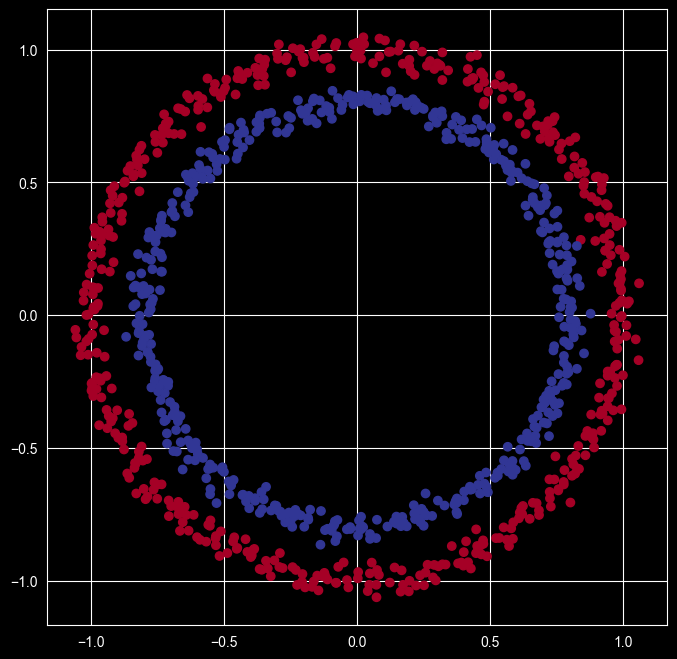

In [318]:
# Visualize the dataset
plt.figure(figsize=(8, 8))

plt.scatter(df['X0'], df['X1'], c=df['label'], cmap=plt.cm.RdYlBu)
plt.show()

In [319]:
# Split the data into training and test sets
test_split = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=seed)

In [320]:
# Covert np.array to torch.Tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

# Make the code device-agnostic
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [321]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [322]:
y_train = y_train.unsqueeze(dim=1)
y_test = y_test.unsqueeze(dim=1)

In [323]:
y_train.shape, y_test.shape

(torch.Size([800, 1]), torch.Size([200, 1]))

## Create the First Model

In [324]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

## Create the Training Loop

In [325]:
def train(model, X_train, y_train, loss_fn, optimizer, epochs=1000, MODEL_PATH=None):
    model.train()

    for epoch in range(epochs):
        # Forward propagation
        y_pred = model(X_train)
        y_pred = y_pred.to(device)

        # Calculate the training loss
        loss = loss_fn(y_pred, y_train)

        # Set optimizer to zero grad
        optimizer.zero_grad()

        # Perform backpropagation
        loss.backward()

        # Step the optimizer
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch} training loss: {loss.item(): .4f}')

    if MODEL_PATH is not None:
        torch.save(model.state_dict(), f=MODEL_PATH)

    return

In [326]:
epochs = 1000
model_1 = CircleModelV1()
model_1.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.1)

train(model=model_1,
      X_train=X_train,
      y_train=y_train,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=epochs)

Epoch 0 training loss:  0.7406
Epoch 100 training loss:  0.6930
Epoch 200 training loss:  0.6930
Epoch 300 training loss:  0.6930
Epoch 400 training loss:  0.6930
Epoch 500 training loss:  0.6930
Epoch 600 training loss:  0.6930
Epoch 700 training loss:  0.6930
Epoch 800 training loss:  0.6930
Epoch 900 training loss:  0.6930


## Create the Testing Loop

In [327]:
def test(model, X_test, y_test):
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_test)

    y_pred = torch.round(torch.sigmoid(y_logits))
    return y_pred

In [328]:
y_pred = test(model=model_1,
              X_test=X_test,
              y_test=y_test)

## Evaluate Model

In [329]:
def compute_recall(y_true, y_pred):
    tp = (y_true * y_pred).sum().item()
    fn = ((1 - y_true) * y_pred).sum().item()

    recall = tp / (tp + fn)
    return recall

In [330]:
def compute_precision(y_true, y_pred):
    tp = (y_true * y_pred).sum().item()
    fp = ((1 - y_true) * y_pred).sum().item()

    precision = tp / (tp + fp)
    return precision

In [331]:
def compute_accuracy(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (correct / len(y_pred)) * 100

    return accuracy

In [332]:
def evaluate(y_true, y_pred):
    recall = compute_recall(y_true, y_pred)
    precision = compute_precision(y_true, y_pred)
    accuracy = compute_accuracy(y_true, y_pred)
    return recall, precision, accuracy

In [333]:
recall, precision, accuracy = evaluate(y_true=y_test,
                                       y_pred=y_pred)

In [334]:
recall, precision, accuracy

(0.4854368932038835, 0.4854368932038835, 48.5)

In [335]:
pred_circles = pd.DataFrame({
    'X0': X_test.cpu()[:, 0],
    'X1': X_test.cpu()[:, 1],
    'label': y_pred.squeeze().cpu()
})

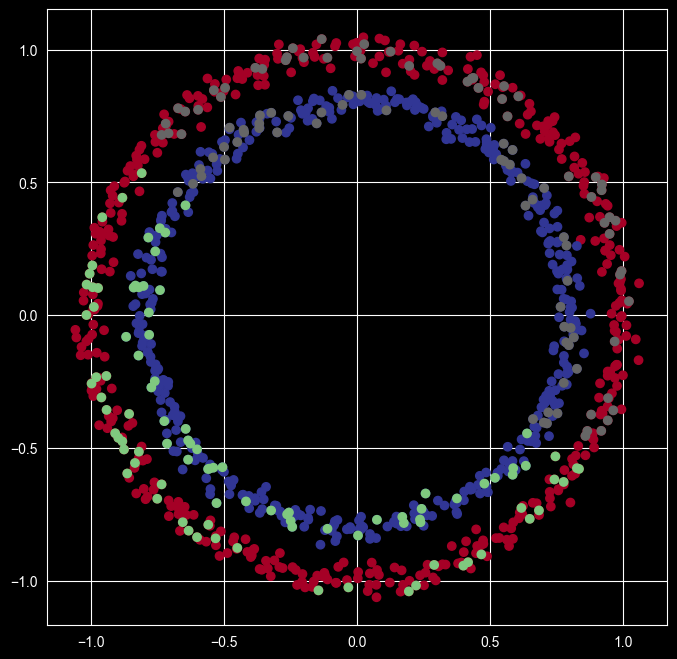

In [336]:
plt.figure(figsize=(8, 8))
plt.scatter(df['X0'], df['X1'], c=df['label'], cmap=plt.cm.RdYlBu)
plt.scatter(pred_circles['X0'], pred_circles['X1'], c=pred_circles['label'], cmap=plt.cm.Accent)
plt.show()

## Non-linear Model

In [337]:
class CirclesModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.relu(self.layer_1(x))
        z = self.relu(self.layer_2(z))
        return self.layer_3(z)

In [338]:
epochs = 1000

model_2 = CirclesModelV2()
model_2.to(device)

loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.1)

In [339]:
train(model_2, X_train, y_train, loss_fn, optimizer, epochs)

Epoch 0 training loss:  0.6951
Epoch 100 training loss:  0.0113
Epoch 200 training loss:  0.0033
Epoch 300 training loss:  0.0016
Epoch 400 training loss:  0.0010
Epoch 500 training loss:  0.0007
Epoch 600 training loss:  0.0005
Epoch 700 training loss:  0.0004
Epoch 800 training loss:  0.0003
Epoch 900 training loss:  0.0002
